In [1]:
import pylab as P
import numpy as np
from scipy import optimize

In [63]:
from IPython.display import HTML

In [64]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
pylab inline

Populating the interactive namespace from numpy and matplotlib


### 1/t decay with only six measurements

Experimental data

In [10]:
xMeas = np.random.uniform(0.5,3.0,size=6)
yTrue = 1.5/xMeas
sError = 0.1
yMeas = yTrue + np.random.normal(scale=sError, size=np.size(yTrue))

In [11]:
xMeas

array([1.52004329, 1.27788965, 2.51629482, 1.74457139, 0.7097523 ,
       0.97233483])

In [6]:
#np.random.normal(scale=sError, size=np.size(yTrue))

In [7]:
#yTrue

In [12]:
yMeas

array([1.13221928, 1.1014492 , 0.67862356, 0.93004422, 2.20397076,
       1.41871618])

Plot to see how the experiment looked

(0.4, 3.0)

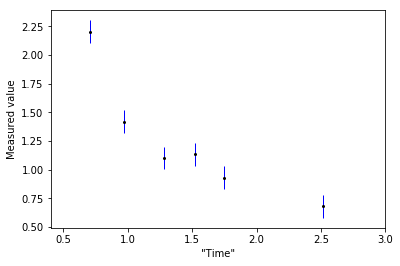

In [13]:
P.errorbar(xMeas,yMeas,yerr=sError,lw=0,elinewidth=1,ecolor='b', fmt='ko',markersize=2)
P.xlabel('"Time"')
P.ylabel('Measured value')
P.xlim(0.4,3.0)

#### Fitting our experimental data

Fit the data with our model

In [14]:
# define a function to fit to the data
def f_decay(x,a,b):
    return a*x**(b)

In [15]:
vGuess = [2.0,-2.0]      # initial guess for parameters; assuming a quadratic when underlying is 1/t

In [16]:
# using scipy's curve_fit to fit the data
# it takes following arguments
# (i) what function to use, (ii) the data to fit, and finally (iii) an initial guess of the parameteres
vPars, aCova = optimize.curve_fit(f_decay, xMeas, yMeas, vGuess)

In [17]:
vPars  # best parameters

array([ 1.52508459, -0.95305366])

In [18]:
aCova  # first of two-return values

array([[ 3.06522019e-03, -1.72519997e-05],
       [-1.72519997e-05,  1.00892400e-02]])

plotting the model over data

Text(0.5,1,'Fitted curve (green) and "truth" curve (red dashed)')

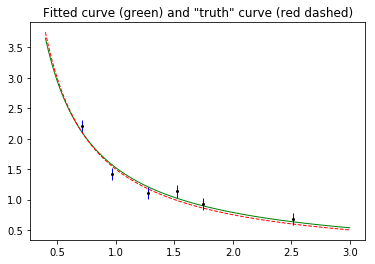

In [19]:
xFine = np.linspace(0.4,3.0,100)
P.errorbar(xMeas,yMeas,yerr=sError,lw=0,elinewidth=1,ecolor='b', fmt='ko',markersize=2)
P.plot(xFine, f_decay(xFine,*vPars), 'g-', lw=1) # Fitted parameters
P.plot(xFine, f_decay(xFine,1.5,-1.0), 'r--', lw=1) # Parameters used to generate data
P.title('Fitted curve (green) and "truth" curve (red dashed)')

#### Monte Carlo - allowing observing times to vary

 we will generate a large number of datasets, re-fit the parameter values where the measurement-times are also not under our experimenter's control, and then find the range of parameters that match the data

In [20]:
nTrials = 4000   
aFitPars = np.array([])        # combined set of best-fit parameters, for all the model parameters (initially empty) 

In [21]:
# simulations
# Each time we need to generate the data as well as fit it

for iTrial in range(nTrials):
    xTrial = np.random.uniform(0.5,3.0,size=np.size(xMeas))
    yGen = 1.5/xTrial
    yTrial = yGen + np.random.normal(scale=sError,size=np.size(yGen))
    
    # We use a try/except clause to catch pathologies
    try:
        vTrial, aCova = optimize.curve_fit(f_decay,xTrial,yTrial,vGuess)
    except:
        dumdum=1
        continue  # This moves us to the next loop without stacking.
    
    #here follows the syntax for stacking the trial onto the running sample:
    if np.size(aFitPars) < 1:
        aFitPars=np.copy(vTrial)
    else:
        aFitPars = np.vstack(( aFitPars, vTrial ))

In [22]:
# size of the set of trials
np.shape(aFitPars)

(4000, 2)

In [23]:
aCova

array([[ 0.05025027, -0.04248852],
       [-0.04248852,  0.04108343]])

In [24]:
np.sqrt(np.diag(aCova))

array([0.22416572, 0.20269048])

This shows that all our 4000 trials were successful. let's look at the distribution of powers of x that came out of the fit:

In [25]:
print(np.median(aFitPars[:,1]))
print(np.std(aFitPars[:,1]))

-0.9976773574225979
0.15034842787256894


0.15034842787256894


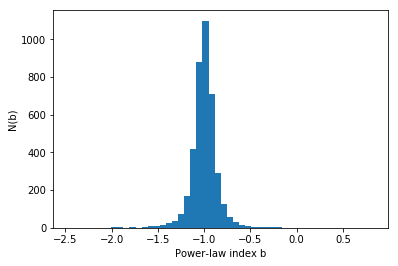

In [26]:
# Graphical look at the parameter
P.hist(aFitPars[:,1],bins=50)
P.xlabel('Power-law index b')
P.ylabel('N(b)')

print(np.std(aFitPars[:,1]))

In [27]:
aFitPars[1:10,1]

array([-1.02786973, -1.09522292, -1.02596196, -1.12481606, -0.80872911,
       -0.9178983 , -0.91909489, -1.07108919, -0.99947883])

We see that the standard deviation of our fitted parameter is pretty high

Text(0,0.5,'Power-law index b')

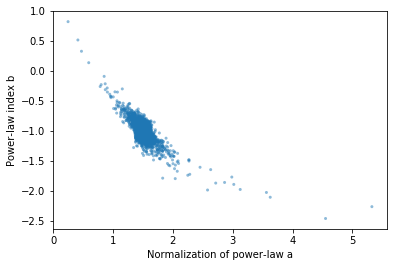

In [28]:
# looking at the power-law components together
P.scatter(aFitPars[:,0], aFitPars[:,1], alpha=0.5, s=9, edgecolor='none')
P.xlabel('Normalization of power-law a')
P.ylabel('Power-law index b')

Text(0,0.5,'Power-law index b')

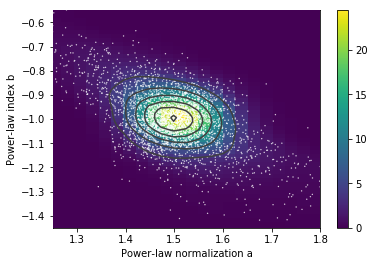

In [29]:
# visualizing in a more appealing way

from scipy.stats import kde
x,y=aFitPars.T

# Use a kernel density estimator to produce local-counts in this space, and grid them to plot.
k = kde.gaussian_kde(aFitPars.T)
nbins=200
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# Show the density
P.pcolormesh(xi, yi, zi.reshape(xi.shape), zorder=3)
P.colorbar()

# Show the datapoints on top of this, and also the contours. "zorder" sets the vertical order in the plot.
P.scatter(aFitPars[:,0], aFitPars[:,1], c='w', s=2, zorder=15, edgecolor='none',alpha=0.75)
P.contour(xi,yi,zi.reshape(xi.shape), zorder=25, colors='0.25')


P.ylim(-1.45,-0.55)
P.xlim(1.25,1.80)
P.xlabel('Power-law normalization a')
P.ylabel('Power-law index b')

Another MC - asking what parameter values we recover if we make identical experiments at the same times as our real data, but still subject to experimental error at those times

In [45]:
aFitSameTimes=np.array([])
for iTrial in range(nTrials):
    yGen = 1.5/xMeas  # Same measured times this time!
    yTrial = yGen + np.random.normal(scale=sError,size=np.size(yGen))
    
    # We use a try/except clause to catch pathologies
    try:
        vTrial, aCova = optimize.curve_fit(f_decay,xMeas,yTrial,vGuess)
    except:
        dumdum=1
        continue  # This moves us to the next loop without stacking.
        
    #here follows the syntax for stacking the trial onto the running sample:
    if np.size(aFitSameTimes) < 1:
        aFitSameTimes=np.copy(vTrial)
    else:
        aFitSameTimes = np.vstack(( aFitSameTimes, vTrial ))

In [46]:
np.shape(aFitSameTimes)

(4000, 2)

-0.9989581136547432
0.08736092255808495


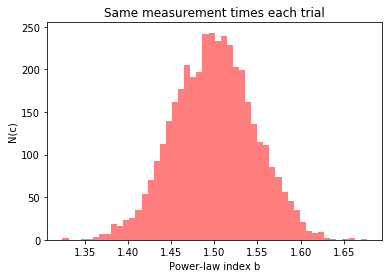

In [47]:
# spread in recovered values
P.hist(aFitSameTimes[:,0],bins=50, alpha=0.5,color='r')
P.xlabel('Power-law index b')
P.ylabel('N(c)')
P.title('Same measurement times each trial')

print(np.median(aFitSameTimes[:,1]))
print(np.std(aFitSameTimes[:,1]))

Text(0.5,1,'Same measurement times each trial')

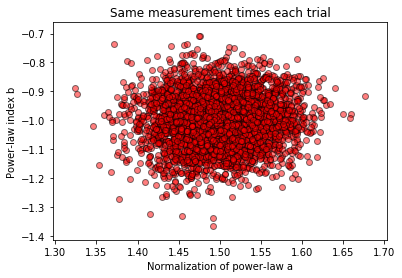

In [48]:
# plotting parameters against each other

P.scatter(aFitSameTimes[:,0], aFitSameTimes[:,1],c='r', s=36, edgecolor='k', alpha=0.5)
P.xlabel('Normalization of power-law a')
P.ylabel('Power-law index b')
P.title('Same measurement times each trial')

# Set the same axis-ranges as above for visual comparison
#P.xlim(1.30, 1.70)
#P.ylim(-1.4,-0.6)

The measurements are still correlated, but the distribution is tighter

Text(0.5,1,'Random observing times (blue) and frozen times (red)')

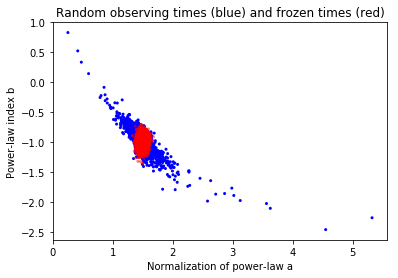

In [49]:
# Plotting the two sets of parameters on top of each other

# the alpha values below are transparency values for plots.
P.scatter(aFitSameTimes[:,0], aFitSameTimes[:,1],c='r', s=9, edgecolor='none', zorder=25, alpha=0.5)
P.scatter(aFitPars[:,0], aFitPars[:,1],c='b', s=9, edgecolor='none', zorder=5)

P.xlabel('Normalization of power-law a')
P.ylabel('Power-law index b')
P.title('Random observing times (blue) and frozen times (red)')

C:\Users\iGuest\Anaconda3\lib\site-packages\matplotlib\contour.py:1004: UserWarning: The following kwargs were not used by contour: 'lw'
  s)


Text(0,0.5,'Power-law index b')

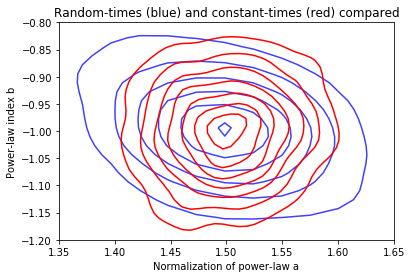

In [50]:
# generating contours and comparing the two sets visually
xS,yS=aFitSameTimes.T
kS = kde.gaussian_kde(aFitSameTimes.T)
nbins=50
xiS, yiS = np.mgrid[xS.min():xS.max():nbins*1j, yS.min():yS.max():nbins*1j]
ziS = kS(np.vstack([xiS.flatten(), yiS.flatten()]))

# Now let's plot this over the previous (xi,yi,zi) case:
P.contour(xi,yi,zi.reshape(xi.shape),colors='b',lw=2, zorder=5, alpha=0.75)
P.contour(xiS, yiS, ziS.reshape(xiS.shape), colors='r', zorder=15, alpha=1.0)

P.xlim(1.35,1.65)
P.ylim(-1.20,-0.80)
P.title('Random-times (blue) and constant-times (red) compared')

P.xlabel('Normalization of power-law a')
P.ylabel('Power-law index b')

In [51]:
aFitSameTimes

array([[ 1.53718701, -1.07257858],
       [ 1.54205584, -0.97925441],
       [ 1.47410155, -0.94761902],
       ...,
       [ 1.5290701 , -1.03456002],
       [ 1.42786242, -1.16876508],
       [ 1.44833123, -1.07248665]])

In [52]:
aCovFit = np.cov(np.transpose(aFitSameTimes))

In [38]:
aCovFit

array([[2.15381979e-03, 8.87503596e-05],
       [8.87503596e-05, 7.48646342e-03]])

The diagonal elements are the variance of each parameter while the off-diagnals indicate the covariance between each pairs of parameters

In [53]:
aCovFit[0,0]

0.0021915848954101105

In [54]:
# standard error
print(np.sqrt(aCovFit[0,0]))

0.046814366335667844


In [55]:
print(np.std(aFitPars[:,0]))

0.1576878613962611


In [56]:
# standard deviation error on parameters
np.sqrt(np.diag(aCovFit))

array([0.04681437, 0.08737184])

In [57]:
# Normalized covriance

np.corrcoef(np.transpose(aFitSameTimes))

array([[1.        , 0.05283272],
       [0.05283272, 1.        ]])

In [58]:
np.sqrt(np.abs(np.corrcoef(np.transpose(aFitSameTimes))))

array([[1.        , 0.22985369],
       [0.22985369, 1.        ]])

In [ ]:
# distribution function
# Cumulrive distribution function
# probability distrinution function
